This project automatically recommends a category for a given product image.  The categories come from the top level of the Google Product Taxonomy (https://www.google.com/basepages/producttype/taxonomy.en-US.txt).  This project was inspired by a post on the Shopify Engineering Blog (https://shopify.engineering/introducing-linnet-using-rich-image-text-data-categorize-products).  Since I had to make my own dataset, I chose to just predict top level categories from images.  In Shopify's model, both product images and other text features like product title or product description are used in making predictions.  Adding text-based features to this model would greatly increase the usefulness of the model, as the mistakes that it makes are reasonable without more context about the product image.

In order to reduce the training time and size requirement for my dataset, I choose to use transfer learning on a pretrained model, replacing the last fully connected layer with a layer sized appropriately to the number of categories that I have.  I am using ResNet-18, an 18 layer residual network trained for ImageNet image classification.  The transfer learning code is inspired by this tutorial: https://pytorch.org/tutorials/beginner/.transfer_learning_tutorial.html

In [45]:
# imports
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import torchvision.transforms.functional as TF

plt.ion()

In [60]:
# data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
    ]),
    'dev': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
    ])
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
device = torch.device('cpu')

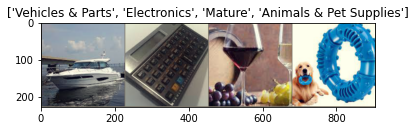

In [47]:
# look at some example from the dataset
def imshow(img, title=None):
    img = img.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
# get a batch
inputs, classes = next(iter(dataloaders['test']))

# make into grid
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [50]:
# define taining
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # best weights are stored and only updated if a better model is found
    # this ensures longer training cannot hurt performance
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # train and validate each epoch
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero gradients at start
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy if is good
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val accuracy: {:4f}'.format(best_acc))
    
    # return best weights
    model.load_state_dict(best_model_wts)
    return model
        
        

In [84]:
# visualize some predictions
def visualize_model(model, num_images=6, data='test'):
    was_training = model.training # store training state to return to proper state
    model.eval()
    image_count = 0
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[data]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                prediction = class_names[preds[j]]
                label = class_names[labels[j]]
                if prediction == label:
                    title = plt.title('{}'.format(class_names[preds[j]]))
                    plt.setp(title, color='g')
                else:
                    title = plt.title('{} ({})'.format(class_names[preds[j]], label))
                    plt.setp(title, color='r')
                imshow(inputs.cpu().data[j])
                image_count += 1

                if image_count == num_images:
                    return
        model.train(mode=was_training)

In [52]:
# load pretrained model
model_fc_only = models.resnet18(pretrained=True)

# turn off training on all layers
for param in model_fc_only.parameters():
    param.requires_grad = False
    
# get the number of input features to the last layer of the model
num_features = model_fc_only.fc.in_features

# replace fully connected layer
model_fc_only.fc = nn.Linear(num_features, len(class_names))

# configure for training
model_fc_only = model_fc_only.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_fc_only.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# train model.  Will take a while, but not too long since it is only training the last layer
model_fc_only = train_model(model_fc_only, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

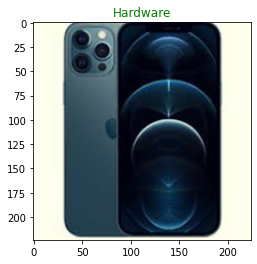

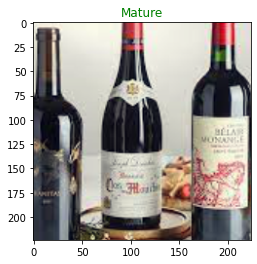

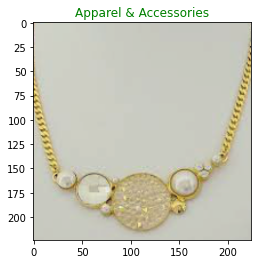

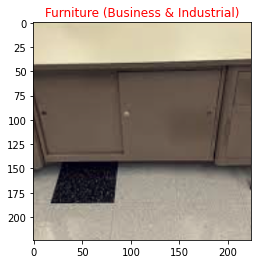

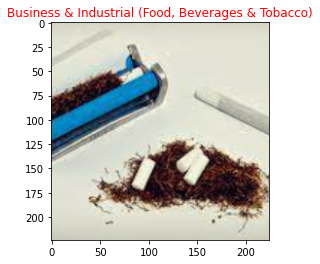

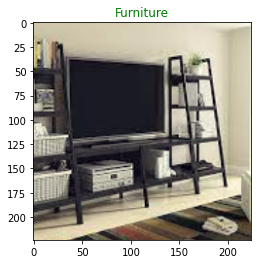

In [85]:
# show some examples from the test dataset
visualize_model(model_fc_only, data='test')

In [61]:
# tests a single image from a file path
def test_img(path):
    image = Image.open(path)
    x = TF.to_tensor(image)
    x.unsqueeze_(0)
    output = model_fc_only(x)
    print(output)
    print(torch.max(output, 1))

In [59]:
# save model and print class names to interpret output
torch.save(model_fc_only, '21categories_model.torch')
print(class_names)
